In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


In [6]:
class AirQualityHealthAnalyzer:
    """Complete analysis system for air quality and health prediction"""

    def __init__(self):
        self.data = {}
        self.merged_data = None
        self.model = None
        self.scaler = StandardScaler()

    def load_multiple_files(self, file_paths):
        """Load multiple CSV files"""
        print("="*60)
        print("LOADING DATA FILES")
        print("="*60)

        for name, path in file_paths.items():
            try:
                df = pd.read_csv(path)
                self.data[name] = df
                print(f"✓ Loaded '{name}': {df.shape[0]} rows, {df.shape[1]} columns")
                print(f"  Columns: {list(df.columns[:5])}..." if len(df.columns) > 5 else f"  Columns: {list(df.columns)}")
            except Exception as e:
                print(f"✗ Error loading '{name}' from {path}: {e}")

        print(f"\nTotal datasets loaded: {len(self.data)}")
        return self.data

    def explore_data(self, dataset_name=None):
        """Explore loaded datasets"""
        print("\n" + "="*60)
        print("DATA EXPLORATION")
        print("="*60)

        datasets = [dataset_name] if dataset_name else list(self.data.keys())

        for name in datasets:
            if name not in self.data:
                print(f"Dataset '{name}' not found")
                continue

            df = self.data[name]
            print(f"\n--- {name.upper()} ---")
            print(f"Shape: {df.shape}")
            print(f"\nFirst few rows:")
            print(df.head())
            print(f"\nData types:")
            print(df.dtypes)
            print(f"\nMissing values:")
            missing = df.isnull().sum()
            if missing.sum() > 0:
                print(missing[missing > 0])
            else:
                print("No missing values")
            print(f"\nNumerical summary:")
            print(df.describe())

    def clean_data(self, dataset_name):
        """Clean and preprocess a dataset"""
        if dataset_name not in self.data:
            print(f"Dataset '{dataset_name}' not found")
            return None

        df = self.data[dataset_name].copy()
        print(f"\nCleaning {dataset_name}...")
        print(f"Original shape: {df.shape}")

        # Convert date columns
        date_cols = ['Date Local', 'Date', 'date', 'Date_Local', 'YEAR', 'Date.Local']
        for col in date_cols:
            if col in df.columns:
                try:
                    df[col] = pd.to_datetime(df[col])
                    print(f"✓ Converted '{col}' to datetime")
                except:
                    pass

        # Handle missing values
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if df[col].isnull().sum() > 0:
                df[col].fillna(df[col].median(), inplace=True)

        # Remove duplicates
        original_len = len(df)
        df = df.drop_duplicates()
        if len(df) < original_len:
            print(f"✓ Removed {original_len - len(df)} duplicates")

        # Remove outliers (using IQR method)
        for col in numeric_cols:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 3 * IQR
            upper = Q3 + 3 * IQR
            before_len = len(df)
            df = df[(df[col] >= lower) & (df[col] <= upper)]
            if len(df) < before_len:
                print(f"✓ Removed {before_len - len(df)} outliers from '{col}'")

        print(f"Cleaned shape: {df.shape}")
        self.data[dataset_name] = df
        return df

In [9]:
def merge_datasets(self, merge_config):
    """Merge multiple datasets"""
    print("\n" + "="*60)
    print("MERGING DATASETS")
    print("="*60)

    merged = None

    for left, right, on_cols, how in merge_config:
        left_df = merged if left == 'merged' else self.data.get(left)
        right_df = self.data.get(right)

        if left_df is None or right_df is None:
            print(f"✗ Cannot merge: missing {left} or {right}")
            continue

        try:
            left_cols = [col for col in on_cols if col in left_df.columns]
            right_cols = [col for col in on_cols if col in right_df.columns]
            merge_cols = list(set(left_cols) & set(right_cols))

            if not merge_cols:
                print(f"✗ No common columns found for merge")
                continue

            merged = pd.merge(left_df, right_df, on=merge_cols, how=how, suffixes=('_left', '_right'))
            print(f"✓ Merged {left} + {right} on {merge_cols}")
            print(f"  Result shape: {merged.shape}")
        except Exception as e:
            print(f"✗ Error merging {left} and {right}: {e}")

    self.merged_data = merged
    return merged

def create_features(self, df=None):
    """Create additional features for modeling"""
    if df is None:
        df = self.merged_data

    if df is None:
        print("No data available for feature creation")
        return None

    df = df.copy()
    print("\n" + "="*60)
    print("FEATURE ENGINEERING")
    print("="*60)

    # Extract date features
    date_cols = df.select_dtypes(include=['datetime64']).columns
    if len(date_cols) > 0:
        date_col = date_cols[0]
        df['Year'] = df[date_col].dt.year
        df['Month'] = df[date_col].dt.month
        df['Day'] = df[date_col].dt.day
        df['DayOfWeek'] = df[date_col].dt.dayofweek
        df['Quarter'] = df[date_col].dt.quarter
        df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
        print("✓ Created temporal features")

    # Create pollution severity categories
    if 'AQI' in df.columns:
        df['AQI_Category'] = pd.cut(df['AQI'],
                                    bins=[0, 50, 100, 150, 200, 300, 500],
                                    labels=['Good', 'Moderate', 'Unhealthy_Sensitive',
                                           'Unhealthy', 'Very_Unhealthy', 'Hazardous'])
        print("✓ Created AQI categories")

    # Rolling averages for pollutants
    pollutant_cols = [col for col in df.columns if any(p in col.lower()
                     for p in ['pm2.5', 'pm10', 'pm 2.5', 'pm 10', 'arithmetic mean',
                               'ozone', 'no2', 'so2', 'co', 'aqi', 'o3'])]

    for col in pollutant_cols[:3]:
        if df[col].dtype in [np.float64, np.int64]:
            df[f'{col}_7day_avg'] = df[col].rolling(window=7, min_periods=1).mean()
            df[f'{col}_30day_avg'] = df[col].rolling(window=30, min_periods=1).mean()

    if pollutant_cols:
        print(f"✓ Created rolling averages for {len(pollutant_cols[:3])} pollutants")

    self.merged_data = df
    return df

# Add these methods to the class
AirQualityHealthAnalyzer.merge_datasets = merge_datasets
AirQualityHealthAnalyzer.create_features = create_features

print("✓ Methods added to AirQualityHealthAnalyzer class")

✓ Methods added to AirQualityHealthAnalyzer class


In [10]:
def visualize_data(self, df=None, save_plots=False):
        """Create visualizations"""
        if df is None:
            df = self.merged_data

        if df is None:
            print("No data available for visualization")
            return

        print("\n" + "="*60)
        print("DATA VISUALIZATION")
        print("="*60)

        sns.set_style("whitegrid")

        # 1. Correlation heatmap
        numeric_df = df.select_dtypes(include=[np.number]).iloc[:, :20]
        if len(numeric_df.columns) > 1:
            plt.figure(figsize=(12, 8))
            correlation = numeric_df.corr()
            sns.heatmap(correlation, annot=False, cmap='coolwarm', center=0)
            plt.title('Feature Correlation Heatmap')
            plt.tight_layout()
            if save_plots:
                plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
            plt.show()
            print("✓ Created correlation heatmap")

        # 2. Time series plot
        date_cols = df.select_dtypes(include=['datetime64']).columns
        pollutant_cols = [col for col in df.columns if any(p in col.lower()
                         for p in ['aqi', 'pm2.5', 'o3', 'no2'])]

        if len(date_cols) > 0 and len(pollutant_cols) > 0:
            plt.figure(figsize=(14, 6))
            df_sorted = df.sort_values(date_cols[0])
            col_to_plot = pollutant_cols[0]
            plt.plot(df_sorted[date_cols[0]], df_sorted[col_to_plot], alpha=0.6)
            plt.title(f'{col_to_plot} Over Time')
            plt.xlabel('Date')
            plt.ylabel(col_to_plot)
            plt.xticks(rotation=45)
            plt.tight_layout()
            if save_plots:
                plt.savefig('timeseries.png', dpi=300, bbox_inches='tight')
            plt.show()
            print("✓ Created time series plot")

        # 3. Distribution plots
        pollutant_cols_dist = [col for col in df.columns if any(p in col.lower()
                         for p in ['pm2.5', 'pm10', 'pm 2.5', 'pm 10', 'arithmetic mean',
                                   'o3', 'no2', 'aqi'])][:4]

        if pollutant_cols_dist:
            fig, axes = plt.subplots(2, 2, figsize=(14, 10))
            axes = axes.ravel()

            for idx, col in enumerate(pollutant_cols_dist):
                if idx < 4:
                    axes[idx].hist(df[col].dropna(), bins=50, edgecolor='black', alpha=0.7)
                    axes[idx].set_title(f'Distribution of {col}')
                    axes[idx].set_xlabel(col)
                    axes[idx].set_ylabel('Frequency')

            plt.tight_layout()
            if save_plots:
                plt.savefig('pollutant_distributions.png', dpi=300, bbox_inches='tight')
            plt.show()
            print("✓ Created distribution plots")

# Add this method to the class
AirQualityHealthAnalyzer.visualize_data = visualize_data

In [12]:
def prepare_for_modeling(self, target_column, feature_columns=None, test_size=0.2):
        """Prepare data for machine learning"""
        df = self.merged_data.copy() if self.merged_data is not None else None

        if df is None and len(self.data) > 0:
            df = list(self.data.values())[0].copy()
            print("Using first loaded dataset for modeling")

        if df is None:
            print("No data available")
            return None

        print("\n" + "="*60)
        print("PREPARING DATA FOR MODELING")
        print("="*60)

        if target_column not in df.columns:
            print(f"✗ Target column '{target_column}' not found")
            print(f"Available columns: {df.columns.tolist()}")
            return None

        if feature_columns is None:
            feature_columns = df.select_dtypes(include=[np.number]).columns.tolist()
            feature_columns = [col for col in feature_columns if col != target_column]

        df_model = df[feature_columns + [target_column]].copy()
        df_model = df_model.dropna()

        print(f"Target: {target_column}")
        print(f"Features ({len(feature_columns)}): {feature_columns[:10]}...")
        print(f"Dataset shape after cleaning: {df_model.shape}")

        X = df_model[feature_columns]
        y = df_model[target_column]

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42
        )

        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        print(f"\nTrain set: {X_train.shape}")
        print(f"Test set: {X_test.shape}")

        return X_train_scaled, X_test_scaled, y_train, y_test, feature_columns

# Add this method to the class
AirQualityHealthAnalyzer.prepare_for_modeling = prepare_for_modeling

In [13]:
def train_model(self, X_train, X_test, y_train, y_test, model_type='rf'):
        """Train prediction model"""
        print("\n" + "="*60)
        print("TRAINING MODEL")
        print("="*60)

        models = {
            'rf': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
            'gb': GradientBoostingRegressor(n_estimators=100, random_state=42),
            'lr': LinearRegression()
        }

        self.model = models.get(model_type, models['rf'])
        model_name = type(self.model).__name__

        print(f"Training {model_name}...")
        self.model.fit(X_train, y_train)

        y_train_pred = self.model.predict(X_train)
        y_test_pred = self.model.predict(X_test)

        print(f"\n{'='*40}")
        print("MODEL PERFORMANCE")
        print(f"{'='*40}")

        print("\nTrain Set:")
        print(f"  R² Score: {r2_score(y_train, y_train_pred):.4f}")
        print(f"  RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.4f}")
        print(f"  MAE: {mean_absolute_error(y_train, y_train_pred):.4f}")

        print("\nTest Set:")
        print(f"  R² Score: {r2_score(y_test, y_test_pred):.4f}")
        print(f"  RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.4f}")
        print(f"  MAE: {mean_absolute_error(y_test, y_test_pred):.4f}")

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.scatter(y_test, y_test_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title('Actual vs Predicted')

        plt.subplot(1, 2, 2)
        residuals = y_test - y_test_pred
        plt.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.title('Residual Distribution')

        plt.tight_layout()
        plt.show()

        return self.model

# Add this method to the class
AirQualityHealthAnalyzer.train_model = train_model

In [16]:
def feature_importance(self, feature_names):
    """Display feature importance"""
    if self.model is None:
        print("No model trained yet")
        return

    if hasattr(self.model, 'feature_importances_'):
        importances = self.model.feature_importances_
        indices = np.argsort(importances)[::-1][:20]

        plt.figure(figsize=(12, 6))
        plt.title("Top 20 Feature Importances")
        plt.barh(range(len(indices)), importances[indices])
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.xlabel("Importance")
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

        print("\nTop 10 Most Important Features:")
        for i in range(min(10, len(indices))):
            idx = indices[i]
            print(f"{i+1}. {feature_names[idx]}: {importances[idx]:.4f}")

def save_model(self, filename='air_quality_model.pkl'):
    """Save trained model"""
    if self.model:
        joblib.dump({'model': self.model, 'scaler': self.scaler}, filename)
        print(f"✓ Model saved to {filename}")

def load_model(self, filename='air_quality_model.pkl'):
    """Load trained model"""
    try:
        loaded = joblib.load(filename)
        self.model = loaded['model']
        self.scaler = loaded['scaler']
        print(f"✓ Model loaded from {filename}")
    except Exception as e:
        print(f"✗ Error loading model: {e}")

# Add these methods to the class
AirQualityHealthAnalyzer.feature_importance = feature_importance
AirQualityHealthAnalyzer.save_model = save_model
AirQualityHealthAnalyzer.load_model = load_model

print("✓ All methods added to AirQualityHealthAnalyzer class successfully!")

✓ All methods added to AirQualityHealthAnalyzer class successfully!


In [17]:
print("#"*60)
print("# AIR QUALITY & PUBLIC HEALTH PREDICTION SYSTEM")
print("#"*60)

analyzer = AirQualityHealthAnalyzer()
print("✓ Analyzer initialized!")

############################################################
# AIR QUALITY & PUBLIC HEALTH PREDICTION SYSTEM
############################################################
✓ Analyzer initialized!


In [18]:
print("\n" + "="*60)
print("STEP 1: LOADING YOUR DATA FILES")
print("="*60)

# UPDATE THESE PATHS TO YOUR ACTUAL FILE LOCATIONS
files = {
    'monitors': 'C:/Users/Dell/Downloads/aqs_monitors.csv',
    'sites': 'C:/Users/Dell/Downloads/aqs_sites.csv',
    'pollution': 'C:/Users/Dell/Downloads/pollution_2000_2023.csv',
    'health': 'C:/Users/Dell/Downloads/PLACES__Local_Data_for_Better_Health,_County_Data_2024_release_20251130.csv'
}

analyzer.load_multiple_files(files)


STEP 1: LOADING YOUR DATA FILES
LOADING DATA FILES
✓ Loaded 'monitors': 367437 rows, 32 columns
  Columns: ['State Code', 'County Code', 'Site Number', 'Parameter Code', 'Parameter Name']...
✓ Loaded 'sites': 20940 rows, 28 columns
  Columns: ['State Code', 'County Code', 'Site Number', 'Latitude', 'Longitude']...
✓ Loaded 'pollution': 665414 rows, 22 columns
  Columns: ['Unnamed: 0', 'Date', 'Address', 'State', 'County']...
✓ Loaded 'health': 240886 rows, 22 columns
  Columns: ['Year', 'StateAbbr', 'StateDesc', 'LocationName', 'DataSource']...

Total datasets loaded: 4


{'monitors':        State Code  County Code  Site Number  Parameter Code  \
 0               1            1            1           11103   
 1               1            1            1           42401   
 2               1            1            2           42401   
 3               1            1            2           44201   
 4               1            1            3           44201   
 ...           ...          ...          ...             ...   
 367432         CC           11            2           68107   
 367433         CC           11            2           68108   
 367434         CC           11            2           68109   
 367435         CC           11            2           88101   
 367436         CC           11            2           88501   
 
                         Parameter Name  POC   Latitude   Longitude  Datum  \
 0       Benzene soluble organics (TSP)    1  32.437458  -86.472891  WGS84   
 1                       Sulfur dioxide    1  32.437458  -86.4

In [19]:
print("\n" + "="*60)
print("CHECKING FOR YOUR REQUIRED VARIABLES")
print("="*60)

air_quality_vars = ['City', 'State', 'Date', 'PM2.5', 'PM10', 'NO2', 'SO2', 'O3', 'CO']
health_vars = ['Asthma', 'COPD', 'Heart Disease', 'Cardiovascular', 'Respiratory',
               'Mortality', 'Hospital', 'Emergency', 'Asthma Rate',
               'Respiratory Hospital Visits', 'Mortality Rate', 'Deaths',
               'Hospitalizations', 'ED Visits', 'Emergency Department']

for name, df in analyzer.data.items():
    print(f"\n{name.upper()} Dataset:")
    
    required_vars = health_vars if name == 'health' else air_quality_vars
    
    found_vars = []
    missing_vars = []
    
    for var in required_vars:
        if var in df.columns:
            found_vars.append(var)
        else:
            similar = [col for col in df.columns if var.lower() in col.lower()]
            if similar:
                found_vars.append(f"{var} (found as: {similar})")
            else:
                missing_vars.append(var)
    
    print(f"✓ Found variables: {found_vars}")
    if missing_vars:
        print(f"✗ Missing variables: {missing_vars}")
    print(f"\nAll columns in {name}: {df.columns.tolist()}")


CHECKING FOR YOUR REQUIRED VARIABLES

MONITORS Dataset:
✓ Found variables: ["City (found as: ['City Name'])", "State (found as: ['State Code', 'State Name'])", "Date (found as: ['Last Sample Date', 'Extraction Date'])", "CO (found as: ['State Code', 'County Code', 'Parameter Code', 'Collecting Agency', 'Last Method Code', 'County Name'])"]
✗ Missing variables: ['PM2.5', 'PM10', 'NO2', 'SO2', 'O3']

All columns in monitors: ['State Code', 'County Code', 'Site Number', 'Parameter Code', 'Parameter Name', 'POC', 'Latitude', 'Longitude', 'Datum', 'First Year of Data', 'Last Sample Date', 'Monitor Type', 'Networks', 'Reporting Agency', 'PQAO', 'Collecting Agency', 'Exclusions', 'Monitoring Objective', 'Last Method Code', 'Last Method', 'Measurement Scale', 'Measurement Scale Definition', 'NAAQS Primary Monitor', 'QA Primary Monitor', 'Local Site Name', 'Address', 'State Name', 'County Name', 'City Name', 'CBSA Name', 'Tribe Name', 'Extraction Date']

SITES Dataset:
✓ Found variables: ["Cit

In [20]:
print("\n" + "="*60)
print("STEP 2: DETAILED DATA EXPLORATION")
print("="*60)

# Explore each dataset
analyzer.explore_data()


STEP 2: DETAILED DATA EXPLORATION

DATA EXPLORATION

--- MONITORS ---
Shape: (367437, 32)

First few rows:
  State Code  County Code  Site Number  Parameter Code  \
0          1            1            1           11103   
1          1            1            1           42401   
2          1            1            2           42401   
3          1            1            2           44201   
4          1            1            3           44201   

                   Parameter Name  POC   Latitude  Longitude  Datum  \
0  Benzene soluble organics (TSP)    1  32.437458 -86.472891  WGS84   
1                  Sulfur dioxide    1  32.437458 -86.472891  WGS84   
2                  Sulfur dioxide    1  32.428470 -86.443585  WGS84   
3                           Ozone    1  32.428470 -86.443585  WGS84   
4                           Ozone    1  32.332659 -86.791521  WGS84   

   First Year of Data  ... NAAQS Primary Monitor QA Primary Monitor  \
0              1974.0  ...                   

In [21]:
print("\n" + "="*60)
print("STEP 3: CLEANING DATA")
print("="*60)

for name in analyzer.data.keys():
    analyzer.clean_data(name)


STEP 3: CLEANING DATA

Cleaning monitors...
Original shape: (367437, 32)
✓ Removed 11332 outliers from 'County Code'
✓ Removed 39242 outliers from 'Site Number'
✓ Removed 2621 outliers from 'POC'
✓ Removed 47 outliers from 'Latitude'
✓ Removed 51 outliers from 'Longitude'
✓ Removed 51532 outliers from 'Last Method Code'
Cleaned shape: (262612, 32)

Cleaning sites...
Original shape: (20940, 28)
✓ Removed 545 outliers from 'County Code'
✓ Removed 1540 outliers from 'Site Number'
✓ Removed 800 outliers from 'Latitude'
✓ Removed 26 outliers from 'Longitude'
✓ Removed 1596 outliers from 'Elevation'
✓ Removed 244 outliers from 'Met Site State Code'
✓ Removed 88 outliers from 'Met Site County Code'
✓ Removed 162 outliers from 'Met Site Distance'
✓ Removed 67 outliers from 'GMT Offset'
✓ Removed 4242 outliers from 'Zip Code'
Cleaned shape: (11630, 28)

Cleaning pollution...
Original shape: (665414, 22)
✓ Converted 'Date' to datetime
✓ Removed 28 outliers from 'O3 Mean'
✓ Removed 271 outliers 

In [22]:
print("\n" + "="*60)
print("STEP 4: CHECKING COLUMNS FOR MERGING")
print("="*60)

for name, df in analyzer.data.items():
    print(f"\n{name.upper()} columns:")
    print(df.columns.tolist())


STEP 4: CHECKING COLUMNS FOR MERGING

MONITORS columns:
['State Code', 'County Code', 'Site Number', 'Parameter Code', 'Parameter Name', 'POC', 'Latitude', 'Longitude', 'Datum', 'First Year of Data', 'Last Sample Date', 'Monitor Type', 'Networks', 'Reporting Agency', 'PQAO', 'Collecting Agency', 'Exclusions', 'Monitoring Objective', 'Last Method Code', 'Last Method', 'Measurement Scale', 'Measurement Scale Definition', 'NAAQS Primary Monitor', 'QA Primary Monitor', 'Local Site Name', 'Address', 'State Name', 'County Name', 'City Name', 'CBSA Name', 'Tribe Name', 'Extraction Date']

SITES columns:
['State Code', 'County Code', 'Site Number', 'Latitude', 'Longitude', 'Datum', 'Elevation', 'Land Use', 'Location Setting', 'Site Established Date', 'Site Closed Date', 'Met Site State Code', 'Met Site County Code', 'Met Site Site Number', 'Met Site Type', 'Met Site Distance', 'Met Site Direction', 'GMT Offset', 'Owning Agency', 'Local Site Name', 'Address', 'Zip Code', 'State Name', 'County 

In [23]:
print("\n" + "="*60)
print("STEP 5: MERGING DATASETS")
print("="*60)

# Start with pollution as base
merged = analyzer.data['pollution'].copy()
print(f"Starting with pollution: {merged.shape}")
print(f"Pollution columns (first 20): {merged.columns.tolist()[:20]}")

# Merge monitors (optional)
if 'monitors' in analyzer.data:
    common_cols = list(set(merged.columns) & set(analyzer.data['monitors'].columns))
    print(f"\nCommon columns with monitors: {common_cols}")
    if len(common_cols) >= 2:
        try:
            merged = pd.merge(merged, analyzer.data['monitors'],
                            on=common_cols[:3], how='left', suffixes=('', '_monitor'))
            print(f"After merging monitors: {merged.shape}")
        except Exception as e:
            print(f"Could not merge monitors: {e}")

# Merge sites (optional)
if 'sites' in analyzer.data:
    common_cols = list(set(merged.columns) & set(analyzer.data['sites'].columns))
    print(f"\nCommon columns with sites: {common_cols}")
    if len(common_cols) >= 2:
        try:
            merged = pd.merge(merged, analyzer.data['sites'],
                            on=common_cols[:3], how='left', suffixes=('', '_site'))
            print(f"After merging sites: {merged.shape}")
        except Exception as e:
            print(f"Could not merge sites: {e}")

# Merge Health data
if 'health' in analyzer.data:
    health_data = analyzer.data['health'].copy()
    health_cols = health_data.columns.tolist()
    print(f"\nHealth data columns (first 20): {health_cols[:20]}")
    
    state_col = [col for col in health_cols if 'state' in col.lower() and 'code' not in col.lower()]
    county_col = [col for col in health_cols if 'county' in col.lower() and 'code' not in col.lower()]
    
    if state_col and county_col:
        state_col = state_col[0]
        county_col = county_col[0]
        print(f"Using health columns: {state_col}, {county_col}")
        
        merged_state = [col for col in merged.columns if 'state' in col.lower() and 'name' in col.lower()]
        merged_county = [col for col in merged.columns if 'county' in col.lower() and 'name' in col.lower()]
        
        if not merged_state:
            merged_state = [col for col in merged.columns if 'state' in col.lower()]
        if not merged_county:
            merged_county = [col for col in merged.columns if 'county' in col.lower()]
        
        if merged_state and merged_county:
            merged_state = merged_state[0]
            merged_county = merged_county[0]
            print(f"Using merged columns: {merged_state}, {merged_county}")
            
            health_outcome_cols = [col for col in health_cols if
                                 'prev' in col.lower() or 'asthma' in col.lower() or
                                 'mortality' in col.lower() or 'copd' in col.lower() or
                                 'hospital' in col.lower() or 'chd' in col.lower() or
                                 'stroke' in col.lower()]
            
            health_subset = health_data[[state_col, county_col] + health_outcome_cols[:20]]
            
            merged = pd.merge(merged, health_subset,
                            left_on=[merged_state, merged_county],
                            right_on=[state_col, county_col],
                            how='left')
            print(f"After merging health data: {merged.shape}")
            print(f"Added health columns: {health_outcome_cols[:10]}")

analyzer.merged_data = merged
print(f"\nFinal merged dataset shape: {merged.shape}")
print(f"Final columns (first 30): {merged.columns.tolist()[:30]}")


STEP 5: MERGING DATASETS
Starting with pollution: (511450, 22)
Pollution columns (first 20): ['Unnamed: 0', 'Date', 'Address', 'State', 'County', 'City', 'O3 Mean', 'O3 1st Max Value', 'O3 1st Max Hour', 'O3 AQI', 'CO Mean', 'CO 1st Max Value', 'CO 1st Max Hour', 'CO AQI', 'SO2 Mean', 'SO2 1st Max Value', 'SO2 1st Max Hour', 'SO2 AQI', 'NO2 Mean', 'NO2 1st Max Value']

Common columns with monitors: ['Address']

Common columns with sites: ['Address']

Health data columns (first 20): ['Year', 'StateAbbr', 'StateDesc', 'LocationName', 'DataSource', 'Category', 'Measure', 'Data_Value_Unit', 'Data_Value_Type', 'Data_Value', 'Data_Value_Footnote_Symbol', 'Data_Value_Footnote', 'Low_Confidence_Limit', 'High_Confidence_Limit', 'TotalPopulation', 'TotalPop18plus', 'LocationID', 'CategoryID', 'MeasureId', 'DataValueTypeID']

Final merged dataset shape: (511450, 22)
Final columns (first 30): ['Unnamed: 0', 'Date', 'Address', 'State', 'County', 'City', 'O3 Mean', 'O3 1st Max Value', 'O3 1st Max H

In [24]:
print("\n" + "="*60)
print("STEP 6: FEATURE ENGINEERING")
print("="*60)

analyzer.create_features()


STEP 6: FEATURE ENGINEERING

FEATURE ENGINEERING
✓ Created temporal features
✓ Created rolling averages for 3 pollutants


,Unnamed: 0,Date,Address,State,County,City,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,...,Year,Month,Day,DayOfWeek,Quarter,IsWeekend,O3 Mean_7day_avg,O3 Mean_30day_avg,O3 1st Max Value_7day_avg,O3 1st Max Value_30day_avg
25,25,2000-01-26,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.020647,0.035,10,32,...,2000,1,26,2,1,0,0.020647,0.020647,0.035000,0.035000
43,43,2000-02-13,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.021765,0.041,10,38,...,2000,2,13,6,1,1,0.021206,0.021206,0.038000,0.038000
51,51,2000-02-21,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.018235,0.031,11,29,...,2000,2,21,0,1,0,0.020216,0.020216,0.035667,0.035667
52,52,2000-02-22,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.019118,0.037,11,34,...,2000,2,22,1,1,0,0.019941,0.019941,0.036000,0.036000
53,53,2000-02-23,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.018000,0.029,10,27,...,2000,2,23,2,1,0,0.019553,0.019553,0.034600,0.034600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665409,665409,2023-06-26,NCore - North Cheyenne Soccer Complex,Wyoming,Laramie,Cheyenne,0.043941,0.050,12,46,...,2023,6,26,0,2,0,0.042358,0.042884,0.051714,0.051633
665410,665410,2023-06-27,NCore - North Cheyenne Soccer Complex,Wyoming,Laramie,Cheyenne,0.046235,0.054,12,50,...,2023,6,27,1,2,0,0.042975,0.042944,0.051286,0.051767
665411,665411,2023-06-28,NCore - North Cheyenne Soccer Complex,Wyoming,Laramie,Cheyenne,0.046588,0.055,7,51,...,2023,6,28,2,2,0,0.043378,0.043105,0.051429,0.051867
665412,665412,2023-06-29,NCore - North Cheyenne Soccer Complex,Wyoming,Laramie,Cheyenne,0.048765,0.056,9,54,...,2023,6,29,3,2,0,0.044412,0.043384,0.052714,0.052067



STEP 7: VISUALIZING DATA

DATA VISUALIZATION


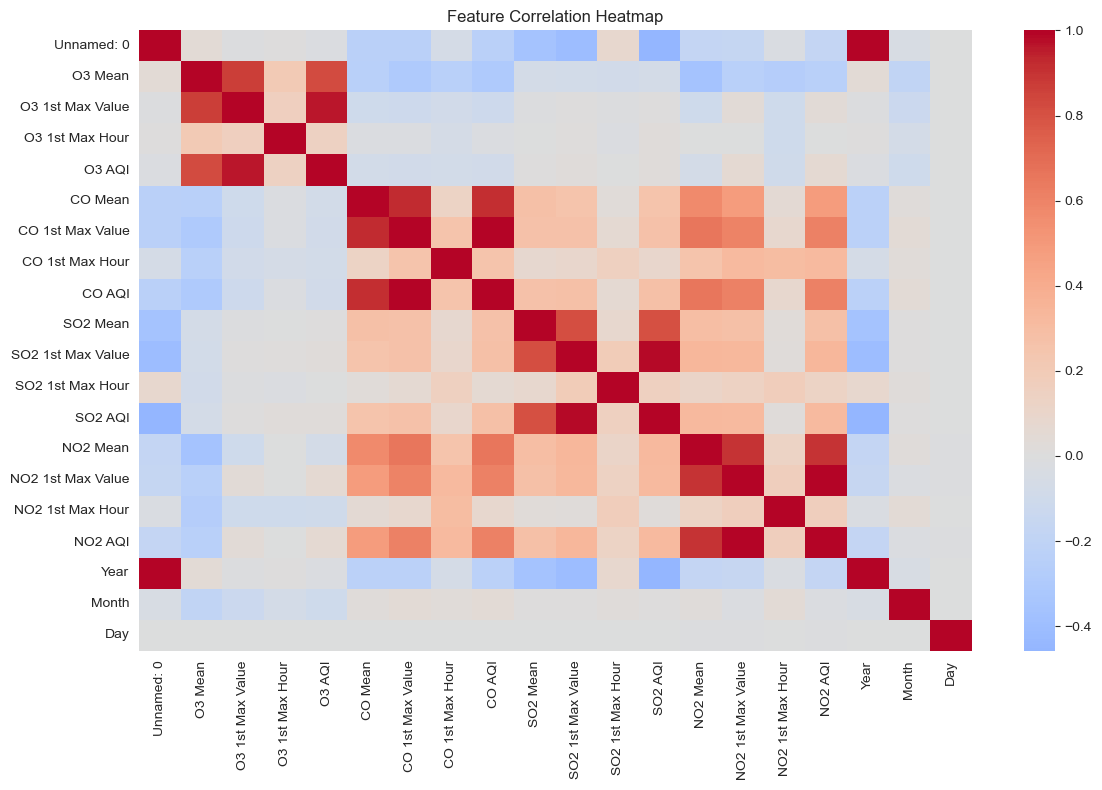

✓ Created correlation heatmap


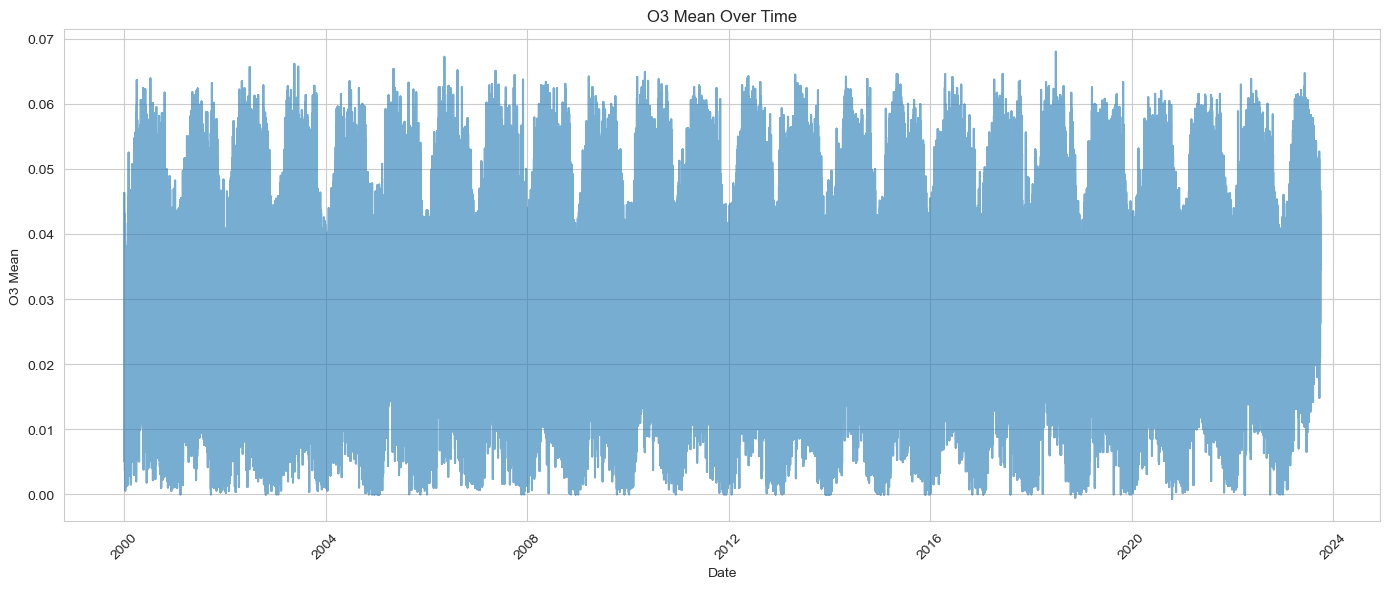

✓ Created time series plot


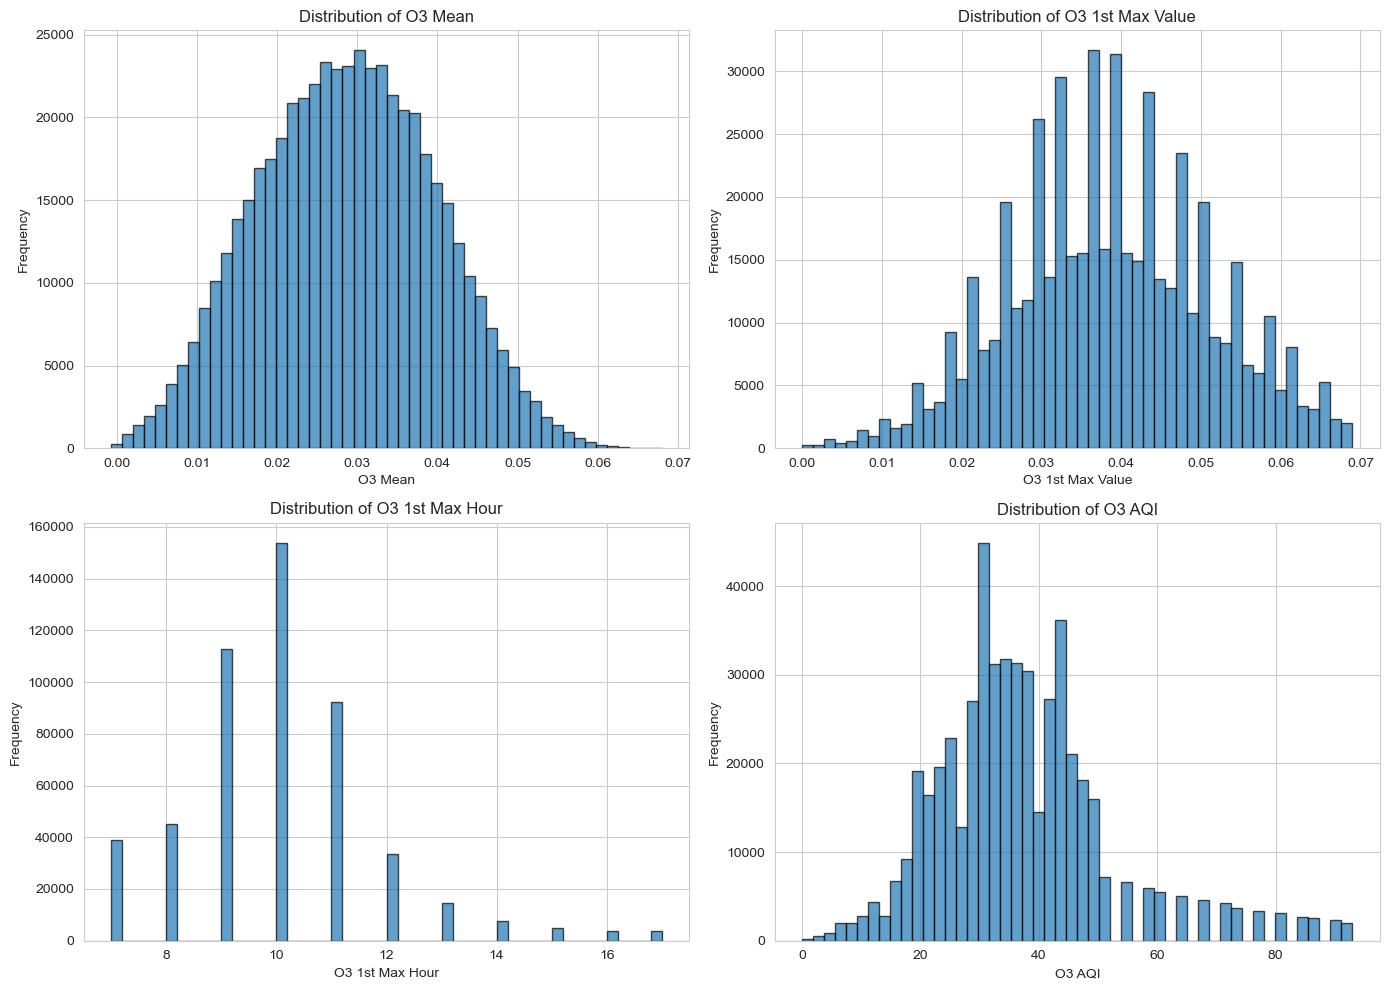

✓ Created distribution plots


In [25]:
print("\n" + "="*60)
print("STEP 7: VISUALIZING DATA")
print("="*60)

analyzer.visualize_data(save_plots=True)

In [26]:
print("\n" + "="*60)
print("STEP 8: FINDING TARGET VARIABLE")
print("="*60)

possible_targets = [
    'CASTHMA_CrudePrev', 'COPD_CrudePrev', 'CHD_CrudePrev', 'STROKE_CrudePrev',
    'Asthma', 'Current asthma among adults aged >=18 years',
    'Respiratory', 'Hospital', 'Mortality',
    'O3 Mean', 'NO2 Mean', 'SO2 Mean', 'CO Mean', 'AQI'
]

target_column = None

print("\nSearching for target variable...")
for col in analyzer.merged_data.columns:
    if col in possible_targets:
        target_column = col
        print(f"  ✓ Found target: {col}")
        break
    for target in possible_targets:
        if target.lower() in col.lower():
            target_column = col
            print(f"  ✓ Found similar target: {col}")
            break
    if target_column:
        break

if target_column:
    print(f"\n✓ Using '{target_column}' as target variable")
else:
    print("\n✗ No suitable target found. Available columns:")
    print(analyzer.merged_data.columns.tolist())


STEP 8: FINDING TARGET VARIABLE

Searching for target variable...
  ✓ Found target: O3 Mean

✓ Using 'O3 Mean' as target variable



STEP 9: TRAINING PREDICTION MODEL

PREPARING DATA FOR MODELING
Target: O3 Mean
Features (26): ['Unnamed: 0', 'O3 1st Max Value', 'O3 1st Max Hour', 'O3 AQI', 'CO Mean', 'CO 1st Max Value', 'CO 1st Max Hour', 'CO AQI', 'SO2 Mean', 'SO2 1st Max Value']...
Dataset shape after cleaning: (511450, 27)

Train set: (409160, 26)
Test set: (102290, 26)

TRAINING MODEL
Training GradientBoostingRegressor...

MODEL PERFORMANCE

Train Set:
  R² Score: 0.9117
  RMSE: 0.0033
  MAE: 0.0026

Test Set:
  R² Score: 0.9116
  RMSE: 0.0033
  MAE: 0.0026


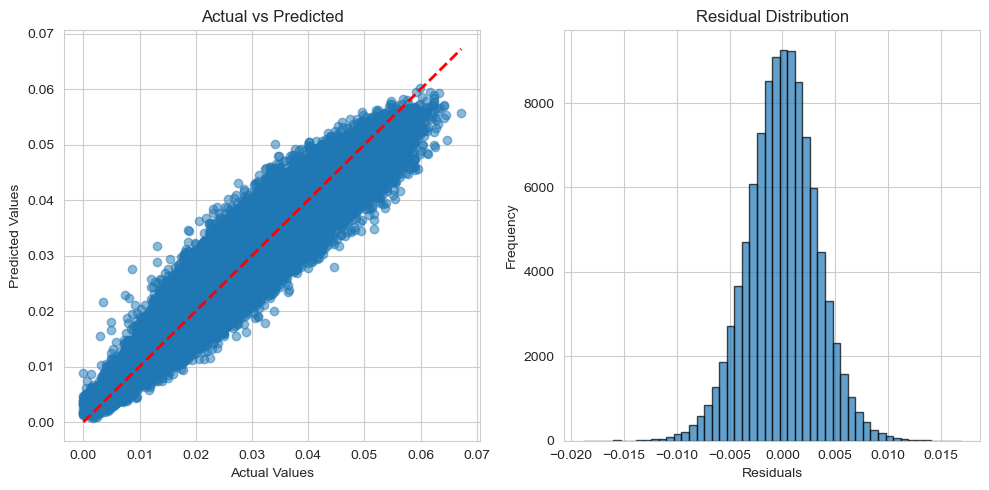

In [27]:
if target_column:
    print("\n" + "="*60)
    print("STEP 9: TRAINING PREDICTION MODEL")
    print("="*60)
    
    data = analyzer.prepare_for_modeling(target_column=target_column)
    
    if data:
        X_train, X_test, y_train, y_test, features = data
        analyzer.train_model(X_train, X_test, y_train, y_test, model_type='gb')
else:
    print("\nSkipping model training - no target variable found")


STEP 10: FEATURE IMPORTANCE ANALYSIS


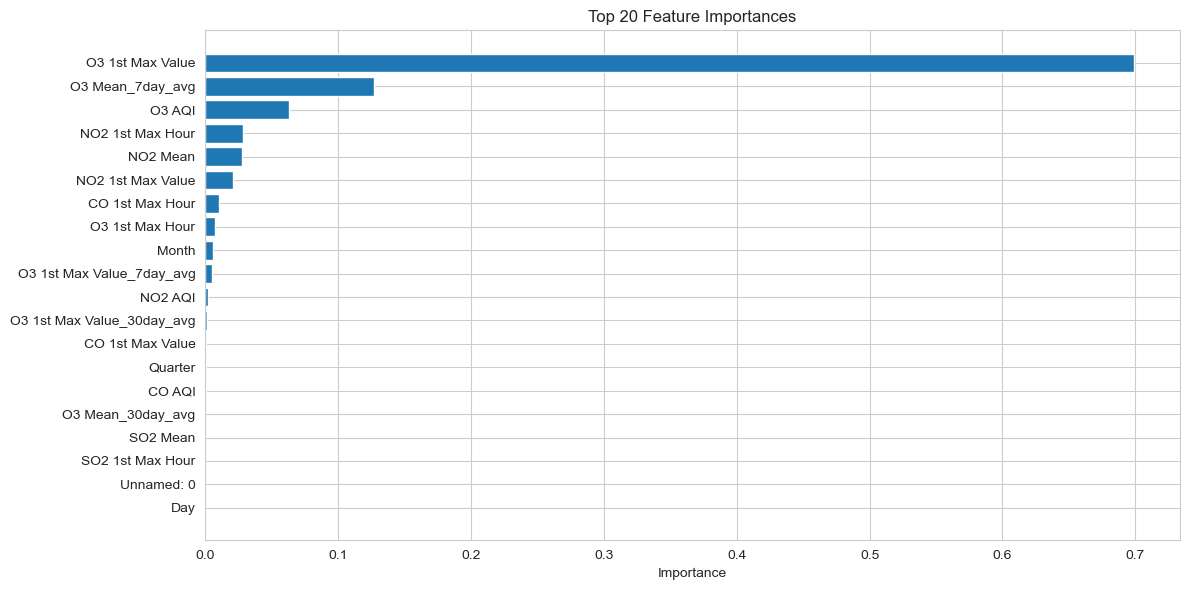


Top 10 Most Important Features:
1. O3 1st Max Value: 0.6987
2. O3 Mean_7day_avg: 0.1270
3. O3 AQI: 0.0628
4. NO2 1st Max Hour: 0.0287
5. NO2 Mean: 0.0274
6. NO2 1st Max Value: 0.0212
7. CO 1st Max Hour: 0.0104
8. O3 1st Max Hour: 0.0070
9. Month: 0.0055
10. O3 1st Max Value_7day_avg: 0.0054


In [28]:
if target_column and data:
    print("\n" + "="*60)
    print("STEP 10: FEATURE IMPORTANCE ANALYSIS")
    print("="*60)
    
    analyzer.feature_importance(features)

In [29]:
if target_column and data:
    analyzer.save_model('air_quality_health_model.pkl')

✓ Model saved to air_quality_health_model.pkl
